## pyspark LR

本篇 jupyter 是在對廣告 log 進行分析。可以學到
* pyspark logistic regreesion(LASSO, ridge)建模方式。
* pipeline 形式的 data transform 方法。

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [11]:
import findspark
findspark.init('/usr/local/spark')
from pyspark.sql import SparkSession
spark_url = "mesos://zk://MESOS_IP:PORT"
hdfs_path = "hdfs://HDFS_ID:PORT"
coresMax = "24"
executorMem = "64g"
appName = "logistic regression"

ss = SparkSession.builder \
    .master( spark_url ) \
    .appName( appName ) \
    .config( "spark.cores.max", coresMax ) \
    .config( "spark.executor.memory", executorMem ) \
    .config( "spark.driver.memory", "24g" ) \
    .config( "spark.driver.maxResultSize", "24g" ) \
    .config( "spark.rpc.message.maxSize", "512") \
    .getOrCreate() 

In [350]:
from pyspark.sql import functions as fn
from pyspark.sql.types import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

### data loading and preprocess

In [4]:
data_path = "HDFS_DATA_PATH"
model_path = "HDFS_MODEL_PATH"

In [138]:
afp_201903 = ss.read.csv(hdfs_path + data_path + "adlog/201903*/", header=True, sep="\t")
col = ss.read.csv(hdfs_path + data_path + "Table_Names/col_adlog")
afp_201903 = afp_201903.toDF(*np.squeeze(col.toPandas().values.tolist())[:42])

In [139]:
# label 整理
afp_201903 = afp_201903.withColumn("label", fn.when(fn.isnull("clickTime"), 0).otherwise(1))

# 時間格式整理
afp_201903 = afp_201903.withColumn("exposureTime", fn.from_unixtime("exposureTime"))
afp_201903 = afp_201903.withColumn("month", fn.month("exposureTime"))
afp_201903 = afp_201903.withColumn("date", fn.dayofmonth("exposureTime"))
afp_201903 = afp_201903.withColumn("weekday", fn.date_format("exposureTime", 'E'))
afp_201903 = afp_201903.withColumn("hour", fn.hour('exposureTime'))
afp_201903 = afp_201903.withColumn("hour_weekday", fn.concat_ws("_", "hour", "weekday"))

In [140]:
# 處理跑行的資料
afp_201903 = afp_201903.withColumn(
    "city_", fn.when(afp_201903["city"].contains("["), afp_201903['country']).otherwise(afp_201903["city"])
)
afp_201903 = afp_201903.withColumn(
    "country_", fn.when(afp_201903["city"].contains("["), afp_201903['OS']).otherwise(afp_201903["country"])
)
afp_201903 = afp_201903.withColumn(
    "OS_", fn.when(afp_201903["city"].contains("["), afp_201903['browser']).otherwise(afp_201903["OS"])
)
afp_201903 = afp_201903.withColumn(
    "browser_", fn.when(afp_201903["city"].contains("["), afp_201903['event']).otherwise(afp_201903["browser"])
)

In [141]:
# 處理城市資訊
afp_201903 = afp_201903.withColumn(
    "city_", fn.when(afp_201903["country_"].contains("Taiwan"), afp_201903['city_']).otherwise("foreign")
)

In [142]:
# catagory columns
cate_cols = ["appId", "clientId", "slotId", "campaignId", "materialId",
             "browser_", "OS_", "city_", "hour", "weekday", 
             "hour_weekday",]

In [10]:
# string to index 一次只能吃一個欄位，要使用 for 迴圈 new 好所有的 column，並包在 list 裏。
indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column+"_id", 
    handleInvalid="skip", 
    stringOrderType="alphabetAsc"
) for column in cate_cols]

# one hot encoder 就可以以 column list 的形式執行。
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{}_encoded".format(indexer.getOutputCol()) for indexer in indexers],
    handleInvalid="keep",
    dropLast=True
)
# 最後將 one hot encoding 的多個稀疏欄位轉為 pyspark ml 可以吃的 vector type
cate_assembler = VectorAssembler(
    inputCols=encoder.getOutputCols(),
    outputCol="features"
)

# 標準化(由於沒有 continue feature, 所以不用標準化)
# scaler = StandardScaler().setInputCol("features").setOutputCol("features_std")

In [11]:
# indexers 是 list type 所以要用 + 來和後面的 list 連接
data_type_transform = Pipeline(stages=indexers + [encoder, cate_assembler,])
data_type_transform_model = data_type_transform.fit(afp_201903)
data_type_transform_model.write().overwrite().save(hdfs_path + model_path + "/afp_pipeline")
afp_fin = data_type_transform_model.transform(afp_201903)

In [12]:
afp_fin.write.parquet(hdfs_path + data_path + "data", mode="overwrite")

In [143]:
ss.stop()

### data training

In [144]:
ss = SparkSession.builder \
    .master( spark_url ) \
    .appName( appName ) \
    .config( "spark.cores.max", coresMax ) \
    .config( "spark.executor.memory", executorMem ) \
    .config( "spark.driver.memory", "24g" ) \
    .config( "spark.driver.maxResultSize", "24g" ) \
    .config( "spark.rpc.message.maxSize", "512") \
    .getOrCreate()

In [145]:
afp_fin = ss.read.parquet(hdfs_path + data_path + "data")

In [16]:
# 資料平衡：使用 weights 來平衡 click(不是 undersample)
label_count = afp_fin.groupBy("label").count().collect()
BalancingRatio = label_count[0][1] / (label_count[0][1]+label_count[1][1])
afp_fin = afp_fin.withColumn(
    "Weights_col", 
    fn.when(afp_fin['label'] == 0, BalancingRatio).otherwise(1-BalancingRatio)
)   
print("balancing ratio = " + str(BalancingRatio))

balancing ratio = 0.0022593539233948844


In [20]:
lr = LogisticRegression(featuresCol="features", 
                        labelCol="label",
                        weightCol="Weights_col",
                        regParam=0.05, 
                        elasticNetParam=1, 
                        family='binomial')
lr_model = lr.fit(afp_fin)
lr_model.write().overwrite().save(hdfs_path + model_path + "/afp_lr")

### data test

In [67]:
afp_test = ss.read.csv(hdfs_path + data_path + "/adlog/2019040*/", header=True, sep="\t")
col = ss.read.csv(hdfs_path + data_path + "Table_Names/col_adlog")
afp_test = afp_test.toDF(*np.squeeze(col.toPandas().values.tolist())[:42])

In [68]:
# label 整理
afp_test = afp_test.withColumn("label", fn.when(fn.isnull("clickTime"), 0).otherwise(1))

# 時間格式整理
afp_test = afp_test.withColumn("exposureTime", fn.from_unixtime("exposureTime"))
afp_test = afp_test.withColumn("month", fn.month("exposureTime"))
afp_test = afp_test.withColumn("date", fn.dayofmonth("exposureTime"))
afp_test = afp_test.withColumn("weekday", fn.date_format("exposureTime", 'E'))
afp_test = afp_test.withColumn("hour", fn.hour('exposureTime'))
afp_test = afp_test.withColumn("hour_weekday", fn.concat_ws("_", "hour", "weekday"))

# 處理跑行的資料
afp_test = afp_test.withColumn(
    "city_", fn.when(afp_test["city"].contains("["), afp_test['country']).otherwise(afp_test["city"])
)
afp_test = afp_test.withColumn(
    "country_", fn.when(afp_test["city"].contains("["), afp_test['OS']).otherwise(afp_test["country"])
)
afp_test = afp_test.withColumn(
    "OS_", fn.when(afp_test["city"].contains("["), afp_test['browser']).otherwise(afp_test["OS"])
)
afp_test = afp_test.withColumn(
    "browser_", fn.when(afp_test["city"].contains("["), afp_test['event']).otherwise(afp_test["browser"])
)

# 處理城市資訊
afp_test = afp_test.withColumn(
    "city_", fn.when(afp_test["country_"].contains("Taiwan"), afp_test['city_']).otherwise("foreign")
)

In [69]:
data_type_transform_model = PipelineModel.load(
    hdfs_path + model_path + "/afp_pipeline"
)
afp_fin = data_type_transform_model.transform(afp_test)

In [70]:
# 因新增的委刊單或是 publisher 而沒進行 data transform 的資料
print("original data count   = {}".format(afp_test.count()))
print("preprocess data count = {}".format(afp_fin.count()))

original data count =   7579814
preprocess data count = 3233033


In [82]:
# 未進行到 preprocess 的資料比例
print("lost {}% data".format(round(((7579814-3233033) / 7579814 * 100), 2)))

lost 57.35% data


In [83]:
lr_model = LogisticRegressionModel.load(hdfs_path + model_path + "/afp_lr")
lr_pred = lr_model.transform(afp_fin)

In [161]:
# 篩選日期，1號、5號、9號各做一次
pred_PDF = lr_pred.where("date == 1").select("probability", "prediction", "label").toPandas()

In [162]:
acc = accuracy_score(pred_PDF['label'], pred_PDF['prediction'])
f1 = f1_score(pred_PDF['label'], pred_PDF['prediction'])
cm = confusion_matrix(pred_PDF['label'], pred_PDF['prediction'])
pred_PDF['pos'] = pred_PDF['probability'].apply(lambda x: x.toArray().tolist()[1])
fpr, tpr, _ = roc_curve(pred_PDF['label'], pred_PDF['pos'])
roc_auc = auc(fpr, tpr)

In [ ]:
# 0401 的測試結果

In [99]:
print("accuracy is {}".format(acc))
cm

accuracy is 0.8786104005234584


array([[515768,  71383],
       [   413,   3887]])

In [100]:
print("f1 score is {}".format(f1))

f1 score is 0.09770013824305643


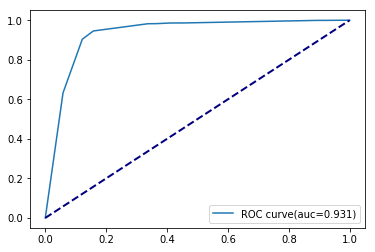

In [101]:
plt.plot(fpr, tpr, label='ROC curve(auc={:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 0405 的測試結果

In [121]:
print("accuracy is {}".format(acc))
cm

accuracy is 0.8441641333655195


array([[204363,  37820],
       [   268,   1960]])

In [122]:
print("f1 score is {}".format(f1))

f1 score is 0.09331555894115406


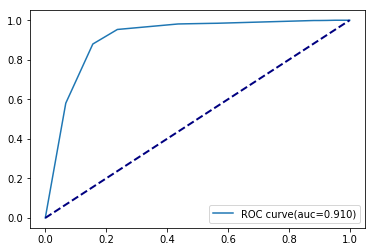

In [123]:
plt.plot(fpr, tpr, label='ROC curve(auc={:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 0409 的測試結果

In [126]:
print("accuracy is {}".format(acc))
cm

accuracy is 0.7511996860836414


array([[205205,  68939],
       [   173,   3464]])

In [127]:
print("f1 score is {}".format(f1))

f1 score is 0.09110994213571805


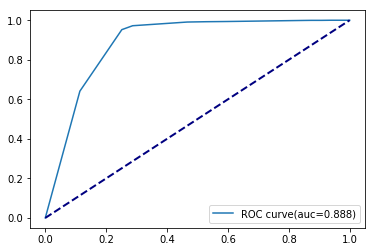

In [128]:
plt.plot(fpr, tpr, label='ROC curve(auc={:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.show()

### 變項解釋

In [214]:
lr_model.coefficients

SparseVector(633, {22: -0.0109, 23: 0.112, 49: 0.5653, 51: 0.4523, 57: 0.5512, 66: -0.1682, 67: -0.1204, 68: -0.1692, 94: -0.0109, 95: 0.112, 99: 1.3216, 122: 0.5653, 124: 0.4523, 130: 0.5512, 143: -0.1692, 144: -0.1204, 145: -0.1682, 154: 1.4011, 307: 0.2996})

對`click`有影響的參數，`publisher`占8個；`client`占9個；`slot`占1個；`OS`占1個。  
而`campaign`都沒有影響。  

In [238]:
data_type_transform_model.stages[-2].categorySizes

[70, 77, 11, 52, 86, 11, 13, 114, 24, 7, 168]

In [5]:
col_info = pd.DataFrame([
    ["app", "client", "slot", "campaign", "material", "browser", "OS", "city", "hour", "weekday", "hour_weekday"],
    ["0~69", "70~146", "147~157", "158~209", "210~295", "296,~306", "307~319", "320~433", "434~457", "458~464", "465~633"],
    [70, 77, 11, 52, 86, 11, 13, 114, 24, 7, 168]
]).T
col_info.columns = ['col_name', 'index', 'num']
col_info

,col_name,index,num
0,app,0~69,70
1,client,70~146,77
2,slot,147~157,11
3,campaign,158~209,52
4,material,210~295,86
5,browser,"296,~306",11
6,OS,307~319,13
7,city,320~433,114
8,hour,434~457,24
9,weekday,458~464,7


In [279]:
ss.stop()